In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import weather_alphas, weather_costs, model

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

### Retrieve Weather Data

In [3]:
all_weather = pd.read_csv("weather01-16.csv")

In [4]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

### Weather Data is only available til Aug of 2016 so use the data til end of 2015. Therefore, dengue data as well

In [5]:
cm_avg_weather = cm_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [120]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction with Mean Temperature"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
    plt.savefig("16-lags-16-weeks-9-temp-wks-chiangmai-00.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [69]:
%%time
cm_16 = weather_alphas.get_alphas(16,9,cm_dengues_train)

running model
getting cost from nweek ahead
bnds 29 [(0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (0.0, None), (None, None), (1.0, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
arr 29 [  0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.05
   0.05   0.05   0.05   0.05   0.05   0.05   0.05   0.75  20.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.  ]
CPU times: user 2h 10min 53s, sys: 18.9 s, total: 2h 11min 12s
Wall time: 2h 11min 37s


In [72]:
cm_16

      fun: 273.15079007717293
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.75522518e+01,   4.42835471e+01,   2.21962182e+00,
        -3.32778427e-01,   2.27373675e-05,   3.97903932e-05,
         3.97903932e-05,   4.54747351e-05,   3.97903932e-05,
         3.41060513e-05,   2.84217094e-05,   2.27373675e-05,
         1.70530257e-05,   1.57619411e+00,   3.08147605e+00,
         6.48214041e+01,   6.46453884e+01,   9.15383680e-01,
        -3.19943183e-01,  -6.77346179e-02,   1.66819518e+00,
         1.33414915e+00,   7.89702881e-01,   4.17009005e-01,
         6.10532425e-01,   1.21076482e+00,   5.86476290e-01,
         2.16061835e-01,  -1.10389919e-01])
  message: 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 15060
      nit: 349
   status: 1
  success: False
        x: array([  1.02033529e-01,   2.27736006e-02,   3.90921405e-03,
         5.71538961e-03,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.

In [194]:
def plot_prediction(LAG, TEMPERATURE_WEEKS, real, ws, province, nweeks_to_predict=[1,2,4,8,16]):

    def n_week_ahead(cases_for_prediction, temps_for_prediction ,weeks_ahead, case_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction.cases)
        for i in range(weeks_ahead):
            week_to_predict = case_week_to_predict + i
#             print week_to_predict
#             print case_week_to_predict + i
#             print case_week_to_predict
#             mean_temp = real.meantemp[]
            cur_prediction = model.guess(
                ws, 
                week_to_predict, 
                prev_cases,
                temps_for_prediction)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,16
        predictions = []
        for start_week in range(len(real)-(LAG)):
            case_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:case_week_to_predict]
            
            temp_week_to_predict = start_week+TEMPERATURE_WEEKS
            temps_for_prediction = real.meantemp[start_week:temp_week_to_predict]
            
            prediction = n_week_ahead(
                cases_for_prediction,
                temps_for_prediction,
                nweek,
                case_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

    ## plot all predictions
    plot_all_predictions(LAG, real.cases, province, nweeks_to_predict, all_predictions)
    
def validation(prediction, real):
    residual_sq = (real - prediction)**2
    real = np.array(real)
    sigma = np.mean(real)**0.5
    score = residual_sq / float(sigma)
    return sum(score) / len(real)

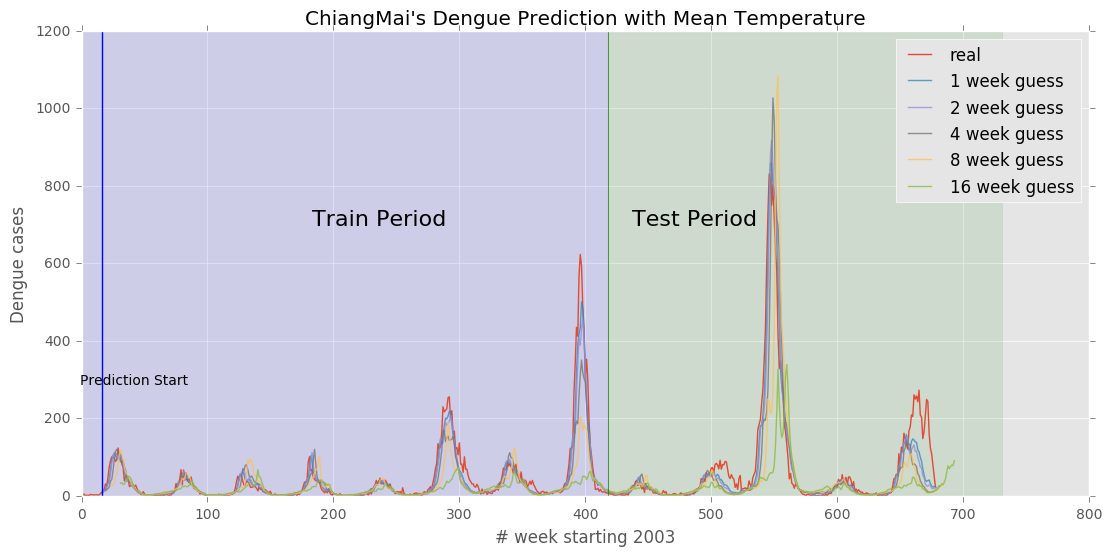

In [138]:
plot_prediction(16, 9, cm_dengues_weather, cm_16.x, "ChiangMai")

In [141]:
for_validation = plot_prediction(16, 9, cm_dengues_weather, cm_16.x, "ChiangMai")

In [196]:
a = [1,2,4,8,12]
for i,e in enumerate(for_validation):
    pred = np.array(e)
    
    print validation(pred[:-a[i]],cm_dengues_weather.cases[16+a[i]:])
    
#     plt.plot(range(len(cm_dengues_weather.cases[16+a[i]:])),cm_dengues_weather.cases[16+a[i]:])
#     plt.plot(pred[:-a[i]])
#     cm_dengues_weather.cases[16+a[i] - 1:] - pred[:a[i]-1]
#     break

235.689359287
329.522458512
637.732006558
1244.68157204
1413.87808048


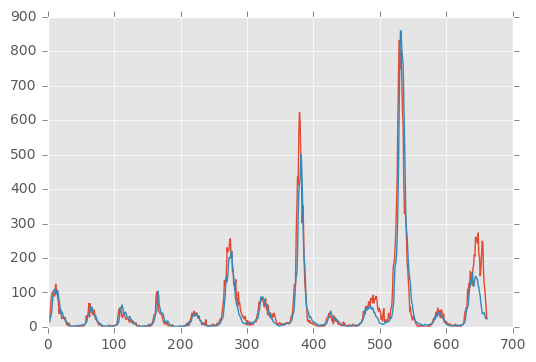

In [187]:
plt.plot(range(len(cm_dengues_weather.cases[16+1:])),cm_dengues_weather.cases[16+1:])
plt.plot(for_validation[0][:-1])


In [193]:
def validation(prediction, real):
    residual_sq = (real - prediction)**2
    real = np.array(real)
    sigma = np.mean(real)**0.5
    score = residual_sq / float(sigma)
    return sum(score) / len(real)

validation(for_validation[0][:-1],cm_dengues_weather.cases[16+1:])

235.68935928683646

In [188]:
np.mean(cm_dengues_weather.cases[16+1:])

56.60725075528701

In [ ]:
## 

In [68]:
def nweek_ahead_cost(ws, week_forward, start_week, end_week, data, cases_for_pred, temps_for_pred):
    
#     print end_week
    ret = 0
    for aweek in range(week_forward): # 16 loops; when you want to predict 14 weeks ahead
        week_to_predict = aweek+end_week
        real_case = data.cases[aweek+end_week] +1 # avoid getting zeros
        
#         print "real",real_case - 1
#         print "mean_temp",mean_temperatures
#         print 'wtp',week_to_predict
#         print cases_for_pred
#         print "tmp_week",aweek,end_temp_wk
#         print "end_week",aweek,end_week
    
        predicted_case = model.guess(
              ws, 
              week_to_predict, 
              cases_for_pred,
              temps_for_pred,
              )
        
        cases_for_pred = np.append(cases_for_pred[1:],predicted_case)
        sigma_sq = real_case + 1
        ret += ((real_case - predicted_case)**2)/float(sigma_sq)
    return ret
    
    
data = cm_dengues_train[:42] #range(1,100)
start_week,end_week,end_temp_wk = 0,16,9
week_forward = 16

all_penalties = []
for real_week in range(len(data)-(week_forward+end_week-1)):
    cases_for_pred = data.cases[start_week:end_week]
    temps_for_pred = data.meantemp[start_week:end_temp_wk]
#     mean_temp = data.meantemp[]
#     print len(cases_for_pred)
#     print 'fw',future_week
#     print "meantemp", data.meantemp[real_week]
    print temps_for_pred
    cur_penalty = nweek_ahead_cost(
        [1.]*29, 
        week_forward, 
        start_week, 
        end_week, 
        data,
        cases_for_pred,
        temps_for_pred)
    
    all_penalties.append(cur_penalty)
        
    start_week+=1
    end_week+=1
    end_temp_wk+=1

# all_penalties

date
2003-01-05    23.500000
2003-01-12    22.828571
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-12    22.828571
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-19    21.457143
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
2003-03-16    26.414286
Freq: W-SUN, Name: meantemp, dtype: float64
date
2003-01-26    20.671429
2003-02-02    22.628571
2003-02-09    22.728571
2003-02-16    24.957143
2003-02-23    24.200000
2003-03-02    24.457143
2003-03-09    25.828571
2003-03-16    26.414286
2003-03-

In [23]:
bng = [(None,None),(1,None)]
[bng.extend([(None,0.)]) for i in range(5)]
bng 

[None, None, None, None, None]

In [ ]:
# def validation():
